# Molecular Isotopic Distributions Take 2: Combinations

This blog post presents a more computationally efficient way to determine the abundance of the molecular isotopes of a molecule.

In [part 1](***), we created a molecule for each possible placement of each isotope in a molecule. While that worked, it was computationally expensive because it required creating each permutation. In this blog post, we'll create each combination only once and calculate its abundance using the binomial distribution. While calculating the molecular isotopes of naphthalene took about 170 seconds using the permutations method, it takes 0.1 seconds using the combinations method below.

While molecular isotope distribution calculations are available on [web sites](https://mstools.epfl.ch/info/) and [desktop software](https://pnnl-comp-mass-spec.github.io/Molecular-Weight-Calculator-VB6/#software-instructions), I was unable to find an open-source option.

In [107]:
%%capture
%!pip install rdkit
%!pip install mendeleev
%!pip install latexify-py

In [108]:
from collections import defaultdict
import math
import copy

from IPython.display import Markdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

import mendeleev
from rdkit import Chem
from rdkit.Chem import Descriptors
import latexify

from typing import Iterable

We'll use the same molecule so we can compare results to the previous blog post. We also copy in code from the previous post.

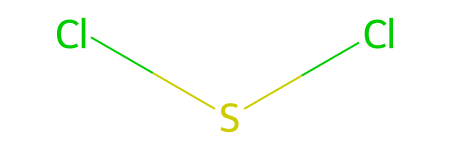

In [109]:
sml = "ClSCl"
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

In [110]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      mol: Chem.rdchem.Mol = None,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    if mol is not None:
      self.mol = mol
    else:
      try:
        self.mol = Chem.MolFromSmiles(sml)
      except:
        self.mol = Chem.MolFromSmiles(sml, sanitize=False)

  def update(self):
    """Define an update method so we can recalculate properties after the atoms' isotopes are set"""
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(self.mol)

  def get_mass(self):
    return self.mass

In [111]:
def composition(
        molecule: Chem.Mol,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            # If isotopes not requested, simply count the number of atoms of each element
            if not isotopes:
                comp[element_symbol] += 1
            # If isotopes requested, count the number of each isotope of each element
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

In [132]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    """Convert an RDKit molecule to a formatted formula, in Markdown and LaTeX

    :param mol: RDKit molecule
    :param isotopes: Whether to consider isotopes
    :returns: a dictionary of format:string pairs, e.g. {"markdown":"markdown_string", "latex":"latex_string"}
    """
    if mol is None:
        return "Invalid molecule"
    comp = composition(mol, isotopes)

    formula = {"markdown": "", "latex": ""}

    if isotopes:
        isotopes_dict = defaultdict(lambda: defaultdict(str))
        subscripts = defaultdict(lambda: defaultdict(int))
        superscripts = defaultdict(list)

        for element, counts in comp.items():
            for isotope, count in counts.items():
                if count > 1:
                    subscripts[element][isotope] = count
                if isotope != 0:
                    superscripts[element].append(isotope)

                isotopes_dict[element][isotope] = 1
            # Sort the element's isotopes from lowest to highest
            superscripts[element].sort()

        last_item_is_subscript = False
        sorted_element_keys = sorted(isotopes_dict.keys())
        for element in sorted_element_keys:
            isotope_count_pairs = isotopes_dict[element]
            # Sort the element's isotopes from lowest to highest
            sorted_isotope_keys = sorted(isotope_count_pairs.keys())
            for isotope in sorted_isotope_keys:
                if element in superscripts:
                    if isotope in superscripts[element]:
                        formula["markdown"] += f"<sup>{isotope}</sup>"

                        # If superscript immediately follows subscript,
                        # add a small amount of horizontal space using an empty group {}
                        # to prevent them from vertically overlapping
                        if last_item_is_subscript:
                            formula["latex"] += "{}"
                        formula["latex"] += "^{ %d}" % isotope
                        last_item_is_subscript = False
                formula["markdown"] += element
                formula["latex"] += element
                last_item_is_subscript = False
                if element in subscripts:
                    if isotope in subscripts[element]:
                        isotope_count = subscripts[element][isotope]
                        formula["markdown"] += f"<sub>{isotope_count}</sub>"
                        formula["latex"] += "_{ %d}" % isotope_count
                    last_item_is_subscript = True
        # Add beginning and ending dollar signs to LaTeX formula
        formula["latex"] = "$" + formula["latex"] + "$"
    else:
        # Handling the case when isotopes is False
        sorted_element_keys = sorted(comp.keys())

        for element in sorted_element_keys:
            count = comp[element]
            formula["markdown"] += element
            formula["latex"] += element
            if count > 1:
                formula["markdown"] += f"<sub>{count}</sub>"
                formula["latex"] += "_{ %d}" % count
        formula["latex"] = "$" + formula["latex"] + "$"

    return formula

In [133]:
def dict_list_to_markdown_table(data: list, number_rows:bool=False) -> str:
    """
    Convert a list of dictionaries into a Markdown table.

    :param data: A list of dictionaries, where each dictionary corresponds to a row in the table.
    :param include_row_numbers: Whether to include a row number column.
    :returns: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table

In [112]:
def flatten_ndarray(arr: np.ndarray) -> list:
    """Flatten an ndarray to a single dimension

    :param arr: the ndarray
    :returns: a one-dimensional list with all the elements from the ndarray
    """
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

## Calculating distributions

Here's a function to calculate the binomial coefficient to choose k items from n items without order or replacement (repetition). We use the [latexify](https://github.com/google/latexify_py) package to automatically create a math equation from the Python code.

In [113]:
@latexify.function
def binomial_coefficient(n: int, k: int) -> int:
    """Calculate the binomial coefficient: how many ways there are to choose k items from n items
    :param n: the number of items to choose from
    :param k: the number of items to choose
    :returns: the number of ways there are to choose k items from n items
    """
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))


binomial_coefficient

We also need to list each distribution of n items in k bins. Here, n is the number of atoms of a given element, and k is the count of a given isotope that will occur in that molecule.

In [114]:
def distribute_items(n:int, k:int) -> list[list[int]]:
    """Calculate the ways to distribute n items amongst k bins
    :param n: the number of items to distribute
    :param k: the number of bins
    :returns: the number of ways there are to choose k items from n items
    """
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

For example, for our four (n=4) chlorine atoms, we have two (k=2) isotopes, 35 and 37. We can thus have
- zero atoms of isotope 35 and four of 37
- one atom of isotope 35 and three of 37
- two atoms of isotope 35 and two of 37
- three atoms of isotope 35 and one of 37
- four atoms of isotope 35 and zero of 37

as given by:

In [115]:
distribute_items(4, 2)

[[0, 4], [1, 3], [2, 2], [3, 1], [4, 0]]

In [116]:
def atom_set(molecule: Chem.Mol) -> set[str]:
    """Get the set of atoms in an RDKit molecule

    :param molecule: The molecule to analyze
    :returns: A set of atomic symbols
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

We define a function to recursively traverse a NumPy array containing objects and extract a given property into an array of the same shape as the original.

In [117]:
def extract_properties(arr:np.ndarray, prop_name:str) -> np.ndarray:
    """For an ndarray where the elements are objects, extract a given property of each object into an array of the same shape as the original

    :param arr: the array or element of an array
    :param prop_name: the name of the property to extract from each object in the array
    :returns: An ndarray of the same shape as the original where the elements are the desired property
    """
    if isinstance(arr, np.ndarray):
        # If arr is a NumPy ndarray, iterate through its elements and apply the function recursively
        return np.array([extract_properties(item, prop_name) for item in arr])
    elif isinstance(arr, list):
        # If arr is a list, iterate through its elements and apply the function recursively
        return [extract_properties(item, prop_name) for item in arr]
    elif hasattr(arr, prop_name):
        # If arr has the specified property, extract its value
        return getattr(arr, prop_name)
    else:
        # If the property is not found, return None
        return None

## Set up

For the isotopes in the molecule, we start by creating a data structure with each element in the molecule. Each element has a nested list of mass number and abundance for each isotope, obtained from the [Mendeleev package](https://pypi.org/project/mendeleev/).

In [118]:
set_of_atoms = atom_set(mol)
isotopes = {}
for atom in set_of_atoms:
  element_isotopes = mendeleev.element(atom).isotopes
  occuring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[atom] = occuring_isotopes
isotopes

{'Cl': [[35, 0.758], [37, 0.242]],
 'S': [[32, 0.9484999999999999],
  [33, 0.0076300000000000005],
  [34, 0.04365],
  [36, 0.00015800000000000002]]}

## Scale of the problem

For a given element, we are applying the element's `n` isotopes to `r` atoms of that element in the molecule. Because we are only concerned with the mass, the placement of the isotopes (which isotope is at which atom) is not important, only their count. So this a combinations with replacement scenario, each isotope can be used more than once so we need the count of each isotope. This is equivalent to painting balls in a jar various colors, where the color represents the isotope, the ball represents an atom in the molecule, and we are not concerned with the order of the balls. The formula for combinations with replacement is:

In [119]:
@latexify.function
def combinations(n, r):
    """Calculate the number of combinations (with repetition, aka replacement) for a choice of k objects from n objects where order does not matter
    :param n: the number of options for an object
    :param r: the number of objects to choose
    :returns: the number of combinations
    """
    return (math.factorial(r + n - 1)) / (math.factorial(r) * math.factorial(n-1))
combinations

To ensure the number of combinations is formatted as an integer, we define a wrapper function:

In [120]:
def combinations_int(n, r):
    """Calculate the number of combinations (with repetition, aka replacement) for a choice of k objects from n objects where order does not matter
    :param n: the number of options for an object
    :param r: the number of objects to choose
    :returns: the number of combinations as an integer
    """
    return int(combinations(n, r))

So for the element S, there are `n = 4` isotopes and `r = 1` atoms, so 4 combinations:

In [121]:
c_S = combinations_int(4,1)
c_S

4

And for Cl, there are `n = 2` isotopes and `r = 2` atoms, so 3 combinations:

In [122]:
c_Cl = combinations_int(2,2)
c_Cl

3

making a total of 12 combinations for the molecule:

In [123]:
c_S * c_Cl

12

which is less than the 16 permutations in the previous post. Here again is the formula for permutations with repetition: 

In [124]:
@latexify.function
def permutations(n:int, r:int) -> int:
    """Calculate the number of permutations (with repetition, aka replacement) for a choice of n options for an object r times where order matters
    :param n: the number of options for an object
    :param r: the number of objects to choose
    :returns: the number of permutations
    """
    return n**r
permutations

While that is a fairly small computational improvement, to understand why using combinations instead of permutations becomes so much more computationally efficient for a large molecule, let's consider a larger molecule, naphthalene, C<sub>10</sub>H<sub>8</sub> (SMILES of `c1c2ccccc2ccc1`). We'll calculate the number of combinations and permutations for each element and for the molecule as a whole:

In [125]:
print("Item  Combinations  Permutations  Combinations more efficient by factor of")
# C
for n_isotopes, n_atoms in [(2, 10)]:
    c_C = combinations_int(n_isotopes, n_atoms)
    p_C = permutations(n_isotopes, n_atoms)
    print(f"C     {c_C:12,} {p_C:13,} {p_C/c_C:11,.2f}")
# H
for n_isotopes, n_atoms in [(2, 8)]:
    c_H = combinations_int(n_isotopes, n_atoms)
    p_H = permutations(n_isotopes, n_atoms)
    print(f"H     {c_H:12,} {p_H:13,} {p_H/c_H:11,.2f}")
print(f"mol   {c_C * c_H:12,} {p_C * p_H:13,} {(p_C * p_H)/(c_C * c_H):11,.2f}")

Item  Combinations  Permutations  Combinations more efficient by factor of
C               11         1,024       93.09
H                9           256       28.44
mol             99       262,144    2,647.92


So by ignoring the order, the number of combinations is significantly less than the number of permutations for for each element. Further, when multiple elements are combined in a molecule, the improvement is multiplicative. This helps explain why calculating the isotopic distribution pattern of naphthalene is very fast using combinations, but much slower using permutations.

The computational efficiency of using combinations instead of permutations would be even greater for elements with more than two isotopes.

From the perspective of the array to hold the molecular isotopes, using permutations requires a dimension for each *atom*, whereas combinations requires a dimension for each *element*. So the more atoms of a given element in a molecule, the more efficient combinations will be compared to permutations.

## Setting the isotope of each atom in each combination

The following function will set the isotope for each atom of a given element. It calculates the abundance based on that element by raising the abundance of an isotope to the power of the count of that isotope in the molecule. When the next element is considered, the code will make independent copies of the molecule that was isotopically labeled for the previous element(s), then apply isotopic labels for the next element. As a result, the isotopic labeling and abundance calculations are done in only one round for each element, lessening the computations required.

In [126]:
def assign_isotopes(
      arr:np.ndarray[MolecularIsotope], 
      isotope_count_distribution: Iterable[Iterable[int]], 
      prefix: list[int],
      this_element: str,
      n_this_element: int,
      ) -> np.ndarray[MolecularIsotope]:
    """Assign the isotope to each atom in each element in an ndarray
    :param arr: the array or element of an array of Molecular isotope objects
    :param isotope_count_distribution: the distribution of isotope counts, e.g. [[0,1], [1,0]] if there are two isotopes and one atom
    :param prefix: the index of this part of the array
    :param this_element: the abbreviation for the current element, e.g. "C" for carbon 
    :param n_this_element: the number of atoms of this element in the molecule
    :returns: the array or element of an array, with atoms' isotopes set
    """
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            new_prefix = prefix + [i]
            assign_isotopes(
               arr = arr[i], 
               isotope_count_distribution = isotope_count_distribution, 
               prefix = new_prefix, 
               this_element = this_element,
               n_this_element = n_this_element,
               )
    else:
        # Clone the distribution, making it independent so the next loop won't be affected
        distribution = copy.deepcopy(isotope_count_distribution[prefix[0]])

        # Calculate abundances
        if arr.abundance is None:
           arr.abundance = 1

        # Set a and b to the multiplicative identity, 1
        a = 1
        b = 1

        # Tracker of how many atoms have yet to be assigned (n)
        n_remaining = n_this_element

        # Iterate through the isotopes
        for isotope_index, isotope_count in enumerate(distribution):
          # Get the abundance of this isotope
          a_this_isotope = isotopes[this_element][isotope_index][1]
          # Multiply the molecule's abundance by the abundance of this isotope to the power of its count
          a *= a_this_isotope**isotope_count

          # k is the count of this isotope
          b_this_isotope = binomial_coefficient(n_remaining, isotope_count)
          b *= b_this_isotope

          # Decrease n, the number of atoms of this element yet to be assigned, by the count of this isotope
          n_remaining -= isotope_count

        # Multiply the abundance of this molecule by the abundance factor and the binomial factor
        arr.abundance *= a*b

        # Assign isotopes to atoms of this element type
        for atom in arr.mol.GetAtoms():
          # If this atom is of the current element, assign an isotope to the atom
          if atom.GetSymbol() == this_element:
            # Count down for each isotope, going on to the next when zero
            for isotope_index, isotope in enumerate(distribution):
              if distribution[isotope_index] > 0:
                  atom.SetIsotope(isotopes[this_element][isotope_index][0])
                  distribution[isotope_index] -= 1
                  # If assign an isotope to this atom, move on to next atom
                  break
        # Update the properties of the MolecularIsotope to get exact masses
        arr.update()
    return arr

This combinations approach is more computationally efficient because we need create only one instance of each isotopologue, then calculate its abundance.

In [127]:
# Initialize ndarray to hold MolecularIsotope objects
molecular_isotopes:np.ndarray = np.array(MolecularIsotope)

# Loop through the elements in this molecule
for this_element, n_this_element in composition(mol).items():
  n_isotopes_this_element = len(isotopes[this_element])

  # Calculate possible distributions of isotopes across atoms of this element
  isotope_count_distribution = distribute_items(n_this_element, n_isotopes_this_element)
  n_distributions = len(isotope_count_distribution)

  if molecular_isotopes.shape == ():
     # Start by creating a 1-dimensional array,
     # making sure to make each mol an independent object
     molecular_isotopes = np.array([MolecularIsotope(sml=sml, mol=Chem.Mol(mol)) for _ in range(n_distributions)], dtype=object)
  else:
    # Create a list of m copies of the current object, 
    # namely the n-1 dimensional ndarray representing elements prior to this element
    molecular_isotopes_list = [copy.deepcopy(molecular_isotopes) for _ in range(n_distributions)]
    
    # Convert the list of copies to a NumPy ndarray
    molecular_isotopes = np.array(molecular_isotopes_list, dtype=object)
    
  # Assign isotopes and abundances
  molecular_isotopes = assign_isotopes(
     arr=molecular_isotopes,
     isotope_count_distribution=isotope_count_distribution, 
     prefix=[],
     this_element=this_element,
     n_this_element=n_this_element,
     )

We can confirm that the array has the expected dimensionality, namely two dimensions, one for S with length four and one for Cl with length 3.

In [130]:
molecular_isotopes.shape

(4, 3)

We can also get the size from the array, and confirm it is 12:

In [129]:
molecular_isotopes.size

12

To sort the isotopologues by mass, we flatten the array into one dimension.

In [131]:
molecular_isotopes_flat = flatten_ndarray(molecular_isotopes)

# Create a list of the masses
masses_array_flat = list(extract_properties(molecular_isotopes_flat, "mass"))

# Create a list of the order (index) of each item by mass, for example the smallest mass will have a value of zero 
order = np.argsort(masses_array_flat).tolist()

# Sort the molecular isotopes by that ordering list
sorted_molecular_isotopes = sorted(molecular_isotopes_flat, key=lambda x: order.index(molecular_isotopes_flat.index(x)))

We also calculate relative abundance--the abundance of each isotopomer relative to the most abundant isotopomer--because that may be convenient to compare to scaled experimental data.

In [135]:
data_dict_list = []
for mol_isotope in sorted_molecular_isotopes:
    mol_isotope.update()
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list).select(["mass", "abundance", "mol"])

max_abundance = df["abundance"].max()

# Add the Markdown and LaTeX formulas, and relative abundance, for each MolecularIsotope
df = df.with_columns(
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["markdown"]).alias("formula"),
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["latex"]).alias("formula_latex"),
    (pl.col("abundance") / max_abundance).alias("relative abundance"),
)

In [136]:
# Choose rows to display in Markdown table
df_display = df.select(["formula", "mass", "abundance", "relative abundance"])
table = dict_list_to_markdown_table(
    df_display.rows(named=True),
    number_rows=True)
Markdown(table)

Markdown(
    dict_list_to_markdown_table(
        df_display.rows(named=True),
        number_rows=True,
        )
    )

| # | formula | mass | abundance | relative abundance |
| --- | --- | --- | --- | --- |
| 1 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 101.90977636 | 0.5449739539999999 | 1.0 |
| 2 | <sup>35</sup>Cl<sub>2</sub><sup>33</sup>S | 102.90916411999999 | 0.00438392332 | 0.00804428044280443 |
| 3 | <sup>35</sup>Cl<sub>2</sub><sup>34</sup>S | 103.90557225999999 | 0.0250797186 | 0.04602003162888772 |
| 4 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 103.90682627 | 0.34797809199999996 | 0.6385224274406333 |
| 5 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 104.90621402999999 | 0.00279923336 | 0.005136453475352696 |
| 6 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 105.90262216999999 | 0.0160139628 | 0.02938482230657211 |
| 7 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 105.90387618 | 0.05554795399999999 | 0.10192772258616968 |
| 8 | <sup>35</sup>Cl<sub>2</sub><sup>36</sup>S | 105.90478612 | 9.078111200000001e-05 | 0.00016657880864522935 |
| 9 | <sup>37</sup>Cl<sub>2</sub><sup>33</sup>S | 106.90326394 | 0.00044684332 | 0.0008199351853795202 |
| 10 | <sup>37</sup>Cl<sub>2</sub><sup>34</sup>S | 107.89967208 | 0.0025563186 | 0.004690717017276022 |
| 11 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 107.90183603 | 5.7965776e-05 | 0.00010636430525632057 |
| 12 | <sup>37</sup>Cl<sub>2</sub><sup>36</sup>S | 109.89888594 | 9.253112e-06 | 1.697899859632558e-05 |


### Checking our abundances

To verify that we calculated abundances correctly, we check that the sum of abundances of the isotopomers is 1. (It might be very slightly different depending on the isotope data, numerical precision of operations, etc.)

In [137]:
mol_isotopes_abundances = df["abundance"].to_list()
abundance_sum = sum(mol_isotopes_abundances)
print(abundance_sum)

0.999938


## Plot abundance vs. mass results

A graph of abundance against mass simulates a mass spectrum. To prevent a forest of short lines and colliding labels due to the be many isotopomers with very low abundance, we might want to limit the plot to a cutoff level of abundance.

In [141]:
cutoff = 0.05
df_cutoff = df.filter(pl.col("abundance") > cutoff)

# Format as Markdown table
df_display_cutoff = df_cutoff.select(["formula", "mass", "abundance", "relative abundance"])
table_cutoff = dict_list_to_markdown_table(
    df_display_cutoff.rows(named=True),
    number_rows=True)
Markdown(table_cutoff)

| # | formula | mass | abundance | relative abundance |
| --- | --- | --- | --- | --- |
| 1 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 101.90977636 | 0.5449739539999999 | 1.0 |
| 2 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 103.90682627 | 0.34797809199999996 | 0.6385224274406333 |
| 3 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 105.90387618 | 0.05554795399999999 | 0.10192772258616968 |


These results agree with the analogous table in the previous blog post. Now we can plot the isotopomers above that cutoff level of abundance.

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


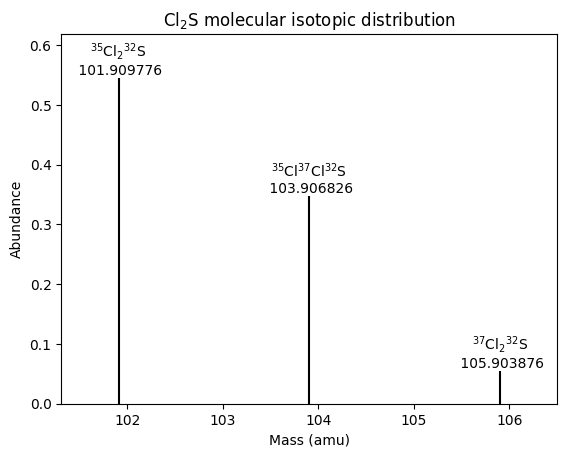

In [140]:
# Create the scatter plot using Seaborn; don't use markers because we'll plot lines instead
sns.scatterplot(x='mass', y='abundance', data=df_cutoff, marker='')

plt.xlabel('Mass (amu)')
plt.ylabel('Abundance')

# Generate molecular formula of molecule
formula = mol_to_formatted_formula(mol)["latex"].strip("$")

# Use C-style string formatting with the % operator to avoid conflicts with using braces for both LaTeX and {}.format()
title = r"${\rm %s}$ molecular isotopic distribution" % formula
plt.title(title)

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df_cutoff['mass']) - min(df_cutoff['mass'])
xpad = xrange * 0.15
plt.xlim(min(df_cutoff['mass']) - xpad, max(df_cutoff['mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df_cutoff['abundance']) - min(df_cutoff['abundance'])
ypad = yrange * 0.15
plt.ylim(0, max(df_cutoff['abundance']) + ypad)

# Iterate through the rows (data points)
for index, (mass, abundance, formula) in enumerate(zip(df_cutoff['mass'], df_cutoff['abundance'], df_cutoff['formula_latex'])):
    # Add vertical lines from each data point to the x-axis
    plt.vlines(x=mass, ymin=0, ymax=abundance, colors='black')

    # Label the data points by mass
    label = r"${\rm %s}$ %s %s" % (formula.strip("$"), "\n", round(mass, 6))
    plt.text(
        x=mass, 
        y=abundance, 
        s=label, 
        ha='center',
        va='bottom')

plt.show()

## Conclusion

Using the binomial distribution to calculate the number of occurrences for each isotopic molecular formula is much more efficient than creating a separate molecule for each position of each isotope. Because all we care about is the molecular mass, it is not important where in the molecule each isotope is, just how many of each isotope there are of each element. Combinations, which ignore the order of isotopic atoms, thus suffice and save computation compared to using permutations, which consider the order of isotopic atoms.